In [1]:
from utils.data_handling import *
from utils.sensor_optimisation_gpy_sparse import *
from parameters import *
import GPy
import scipy.stats
from sklearn.covariance import GraphicalLasso

import seaborn as sns

import matplotlib.pyplot as plt
np.random.seed(101)
%matplotlib inline

### Importing the Tracer Data to Select the Optimisation set S

In [2]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters

{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [3]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


### Working subset of the data : set S

In [4]:
S = working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-2 )

The remaining number of points is :  57725


### Import the Field of interest for computing the optimisation : TracerBackground / Pressure

In [5]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [6]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


In [7]:
X = loc_df.values #[I,:dim]
Z = data_df.values#[:,t].reshape(-1,1) # [I,t].reshape(-1,1)
Z.shape

(100040, 989)

### Detrending Data : 
Plotting the data along each direction in order to see if there is a obvious trend. It seams that it is not the case. 

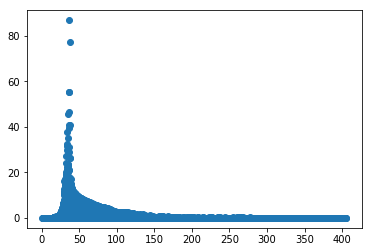

In [20]:
plt.scatter(np.linalg.norm(X[S,:],axis=1),Z[S,:].sum(axis=1))


Temporal Analysis : 

In [9]:
# Threshold bellow which everything is zero : 
thresh = 0.0001

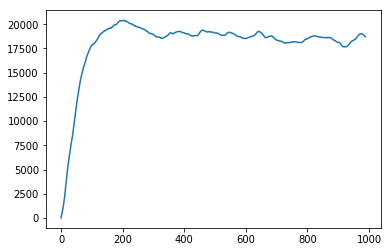

In [10]:
# plot of the non zero elements in function of the time 
plt.plot(np.sum(Z[S,:]>=thresh,axis=0));

In [11]:
Z[Z<thresh] = 0
Z = Z[:,200:]
Z.shape

(100040, 789)

What should I do : 
- Cut the time at 200: ?
- replace the values bellow the threshold by 0 ? 


In [8]:
Z[S,:] = (Z[S,:] - Z[S,:].mean(axis=1,keepdims=True))

In [9]:
Z[S[:1000],:].shape

(1000, 989)

In [11]:
#%%time
Cor_SS = np.corrcoef(Z[S[:],:])
Cor_SS


array([[ 1.        ,  0.95559373,  0.70132332, ...,  0.03796989,
         0.11068398,  0.11104625],
       [ 0.95559373,  1.        ,  0.80370953, ...,  0.05284998,
         0.13828184,  0.13824287],
       [ 0.70132332,  0.80370953,  1.        , ..., -0.28798568,
        -0.18361885, -0.18781343],
       ...,
       [ 0.03796989,  0.05284998, -0.28798568, ...,  1.        ,
         0.85065812,  0.84083203],
       [ 0.11068398,  0.13828184, -0.18361885, ...,  0.85065812,
         1.        ,  0.99694489],
       [ 0.11104625,  0.13824287, -0.18781343, ...,  0.84083203,
         0.99694489,  1.        ]])

In [16]:
6.50236874e-15 / np.sqrt(5.79668733e-14 * 1.58766630e-13)

6.50236874e-15

In [19]:
np.sqrt(5.79668733e-14 * 1.58766630e-13)

9.593333688284787e-14

In [12]:
(Cor_SS.sum(axis=1) <= 0.1).sum()

8966

In [13]:
Cov_SS = np.cov(Z[S[:],:])
Cov_SS


array([[ 5.79668733e-14,  6.50236874e-15,  7.93576017e-19, ...,
         1.86280728e-14,  1.58766630e-13,  7.50030758e-14],
       [ 6.50236874e-15,  7.98760775e-16,  1.06754895e-19, ...,
         3.04363022e-15,  2.32840235e-14,  1.09606512e-14],
       [ 7.93576017e-19,  1.06754895e-19,  2.20882156e-23, ...,
        -2.75797240e-18, -5.14140838e-18, -2.47623709e-18],
       ...,
       [ 1.86280728e-14,  3.04363022e-15, -2.75797240e-18, ...,
         4.15219181e-12,  1.03270977e-11,  4.80654712e-12],
       [ 1.58766630e-13,  2.32840235e-14, -5.14140838e-18, ...,
         1.03270977e-11,  3.54951534e-11,  1.66625297e-11],
       [ 7.50030758e-14,  1.09606512e-14, -2.47623709e-18, ...,
         4.80654712e-12,  1.66625297e-11,  7.86992348e-12]])

In [14]:
(Cov_SS.sum(axis=1) == 0.0).sum()

0

In [17]:
cov_SS_lasso = GraphicalLasso(verbose=True).fit(Z[S[:3000],:].T)


[graphical_lasso] Iteration   0, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration   1, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration   2, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration   3, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration   4, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration   5, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration   6, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration   7, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration   8, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration   9, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration  10, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration  11, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration  12, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration  13, cost -1.74e+34, dual gap -1.745e+34
[graphical_lasso] Iteration  14, c

 /home/aml718/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning:graphical_lasso: did not converge after 100 iteration: dual gap: -1.745e+34


In [20]:
cov_SS_lasso.covariance_.shape


NameError: name 'cov_SS_lasso' is not defined

In [70]:
Z[S[:],:]

(57725, 789)

In [16]:
Cov_SS.shape

(57725, 57725)

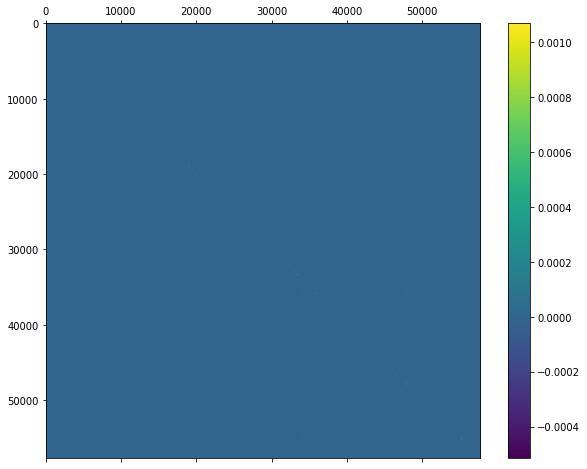

In [18]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(Cov_SS)
fig.colorbar(cax)

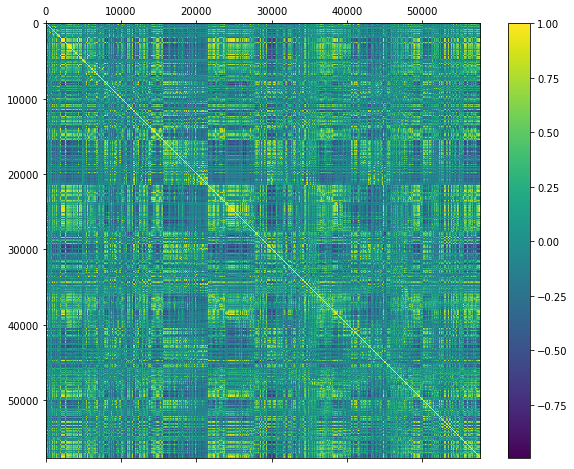

In [18]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(Cor_SS)
fig.colorbar(cax)